In [142]:
using JuMP, Gurobi, Ipopt,AmplNLWriter, NLopt
using Mosek, Cbc

In [154]:
k = 3              # number of waypoints
T = zeros(Int,k)   # vector of timepoints
xw = zeros(2,k)    # vector of waypoint locations
xθw = zeros(1,k)

T[1] = 1
T[2] = 20
T[3] = 60

# define waypoints
xw = [ 1   8   18
       1   6   0]

# define waypoints
#xθw = [π/2  π/2  π/2]

L = .1 # length of car
;

In [162]:
m = Model(solver=AmplNLSolver("bonmin"))

@variable(m, x[1:2,1:T[k]])  # Inertial frame
@variable(m, θ[1:T[k]])      # Inertial frame orientation
@variable(m, -π/10 <= ϕ[1:T[k]] <= π/10)      # steering angle

@variable(m, vx[1:2,1:T[k]]) # velocity in inertial frame
@variable(m, v[1:T[k]])      # wheel velocity in body frame
@variable(m, vθ[1:T[k]])     # Orientation change velocity
@variable(m, -π/15 <= vϕ[1:T[k]] <= π/15)     # Orientation change velocity

@variable(m, -1 <= u[1:T[k]] <= 1)      # thruster input
#@variable(m, a[1:T[k]] >= 0)      # acceleration
#@variable(m, b[1:T[k]] >= 0)      # brakes
#@variable(m , aOrb[1:T[k]], Bin)

# satisfy the dynamics (with zero initial velocity)
@constraint(m, vx[:,1] .== [0;0])
@constraint(m, v[1] == 0)
@constraint(m, u[1] == 0)
@constraint(m, ϕ[1] == 0)
@constraint(m, vϕ[1] == 0)
#@constraint(m, θ[1] == π/2)

for t in 1:T[k]-1
    @constraint(m, x[:,t+1] .== x[:,t] + vx[:,t])
    @constraint(m, θ[t+1] == θ[t] + vθ[t])
    @constraint(m, ϕ[t+1] == ϕ[t] + vϕ[t])
    @constraint(m, v[t+1] == v[t] + u[t])
    #@constraint(m, u[t+1] == u[t] + a[t] - b[t])
    #@constraint(m, a[t+1] == a[t] - b[t])
    #@constraint(m, b[t] <= a[t])
end
for t in 1:T[k]  
    @NLconstraint(m, vx[1,t] == v[t]*cos(θ[t]))
    @NLconstraint(m, vx[2,t] == v[t]*sin(θ[t]))
    @NLconstraint(m, vθ[t] == (v[t]/L)*tan(ϕ[t]))
end

# hit all waypoints
for i in [1 k]
    @constraint(m, x[:,T[i]] .== xw[:,i])
    #@constraint(m, θ[T[i]] == xθw[i])
end

@expression(m, distance, sum(sum((x[:,t+1] - x[:,t]).^2) for t in 1:T[k]-1))
# minimize 2-norm (THIS IS LEAST-SQUARES)
λ = 100
@objective(m, Min, sum(u.^2) + 
    λ*sum( (x[:,T[2:k]]-xw[:,2:k]).^2  ) + 0.0sum( (θ[T[2:k]]-xθw[2:k]).^2  )
    + 0.0distance)

solve(m)

Bonmin 1.8.4 using Cbc 2.9.7 and Ipopt 3.12.4
bonmin: 
Cbc3007W No integer variables - nothing to do

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT 1.8189894e-12      231 1.045451
Cbc3007W No integer variables - nothing to do

 	"Finished"


:Optimal

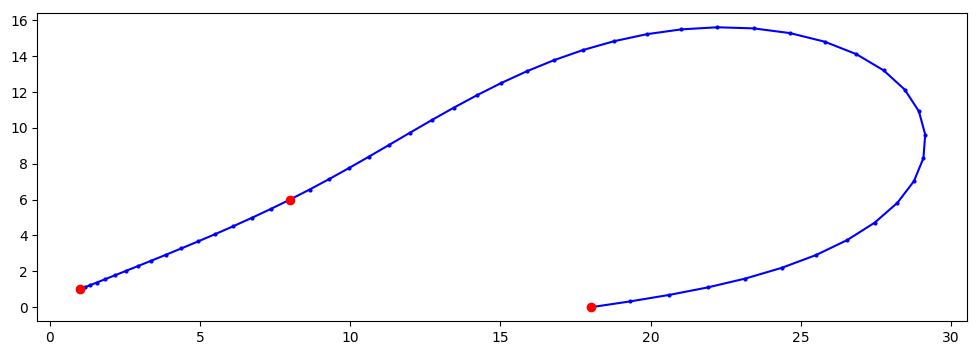

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x329c9ed90>

In [163]:
using PyPlot
figure(figsize=(12,4))
xopt = getvalue(x)
plot( xopt[1,:][:], xopt[2,:][:], "b.-", markersize=4 )
plot( xw[1,:], xw[2,:], "r.", markersize=12 )

In [164]:
getvalue(distance)

57.913632426583774

In [147]:
xopt = getvalue(x)

2×20 Array{Float64,2}:
 1.0  1.0  1.0  1.0     1.00096  …  5.28416  6.17444  7.0828   8.0  8.0
 1.0  1.0  1.0  1.0947  1.28623     5.97015  6.04475  6.04647  6.0  6.0

In [148]:
θopt = getvalue(θ)'

1×20 Array{Float64,2}:
 1.5708  1.5708  1.5708  1.56577  …  -0.0506168  -0.0789483  -0.0789483

In [149]:
ϕopt = getvalue(ϕ)'

1×20 Array{Float64,2}:
 -5.71068e-32  -1.7132e-31  -0.00530869  …  -0.00176069  -0.00121894

In [150]:
uopt = getvalue(u)'

1×20 Array{Float64,2}:
 2.05925e-31  0.0946969  0.0968342  …  0.00508356  7.90621e-17  0.0

In [151]:
vopt = getvalue(v)'

1×20 Array{Float64,2}:
 1.44767e-31  5.56617e-31  0.0946969  …  0.918379  0.923462  0.923462

In [152]:
vxopt = getvalue(vx)

2×20 Array{Float64,2}:
 1.01296e-33  2.02593e-33  5.79851e-18  …   5.54694e-9    5.54694e-9 
 8.36096e-32  5.79069e-31  0.0946969       -4.38834e-10  -4.38834e-10

In [153]:
vϕopt = getvalue(vϕ)'

1×20 Array{Float64,2}:
 -5.71068e-32  -0.00530869  -0.00513819  …  0.00132426  0.000541754  0.0